# Cuerno Clase PLN - Introducción a Word Embeddings y Word2Vec

**Objetivos:**
*   Entender las limitaciones de BoW/TF-IDF.
*   Comprender el concepto de Word Embeddings (vectores densos semánticos).
*   Conocer las arquitecturas Word2Vec (CBOW y Skip-gram).
*   Aprender a cargar y usar vectores Word2Vec pre-entrenados con `gensim`.
*   Explorar similitud y analogías entre palabras.
*   (Opcional) Visualizar embeddings.

**Agenda:**
1.  Instalaciones e Importaciones
2.  ¿Por qué necesitamos algo mejor que BoW/TF-IDF?
3.  La Idea Clave: Word Embeddings
4.  Word2Vec: Aprendiendo de los Vecinos (CBOW y Skip-gram)
5.  Usando Vectores Pre-entrenados (¡Importante!)
6.  Cargando Vectores con Gensim
7.  Explorando los Vectores: Similitud y Analogías
8.  (Opcional) Visualización de Embeddings
9.  Micro-Laboratorio (Ejercicio Práctico)
10. Brainstorming: Sesgos en Embeddings

# 1. Instalaciones e Importaciones

In [ ]:
# Gensim es la librería clave para trabajar con Word2Vec, GloVe, FastText
!pip install gensim matplotlib seaborn scikit-learn > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.1 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [ ]:
!pip uninstall gensim -y # Remove the existing gensim installation
!pip install gensim # Reinstall gensim to align with the NumPy version
# Restart the kernel to ensure the changes take effect

Found existing installation: gensim 4.3.3
Uninstalling gensim-4.3.3:
  Successfully uninstalled gensim-4.3.3
  Using cached gensim-4.3.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
Using cached gensim-4.3.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.6 MB)


In [ ]:
import gensim
from gensim.models import KeyedVectors # Para cargar modelos pre-entrenados
import numpy as np
import warnings
warnings.filterwarnings('ignore') # Para evitar warnings de gensim a veces

# Para visualización (Opcional)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

print("Librerías importadas.")
# Nota: Más adelante necesitaremos descargar un archivo de vectores pre-entrenados.

Librerías importadas.


# 2. ¿Por qué necesitamos algo mejor que BoW/TF-IDF?

Recordemos rápido las limitaciones de las representaciones que vimos previamente:

*   **Vectores Enormes y Dispersos:** Si tenemos 50,000 palabras únicas, cada documento es un vector de 50,000 dimensiones, ¡casi todo ceros! Muy ineficiente.
*   **No Capturan Significado (Semántica):**
    *   Las palabras "coche" y "auto" son sinónimos, pero para BoW/TF-IDF son tan diferentes entre sí como lo son de "banana". Cada una es una columna distinta.
    *   No hay noción de que "perro" y "gato" son más parecidos entre sí que "perro" y "mesa".
*   **Ignoran el Orden de las Palabras:** "Perro muerde a hombre" y "Hombre muerde a perro" tienen representaciones muy similares (mismas palabras, distintos conteos quizás, pero misma bolsa).

Necesitamos una forma de representar palabras que capture su **significado** y las **relaciones** entre ellas.

# 3. La Idea Clave: Word Embeddings

¡Aquí entran los **Word Embeddings** (incrustaciones de palabras)!

*   **Idea Central:** Representar cada palabra como un **vector denso** (la mayoría de valores NO son cero) en un espacio de **menor dimensión** (ej: 50, 100, 300 dimensiones, ¡no 50,000!).
*   **La "Magia":** Estos vectores no son aleatorios. Se aprenden de grandes cantidades de texto de forma que palabras con **significados similares** terminan teniendo **vectores cercanos** en ese espacio vectorial.
    *   El vector de "gato" estará cerca del vector de "perro".
    *   El vector de "contento" estará cerca del vector de "feliz".
*   **Analogía:** Imaginen un mapa. Cada ciudad es una palabra. Las ciudades cercanas en el mapa representan palabras semánticamente relacionadas.
*   **¡Álgebra de Palabras!** Lo más sorprendente es que la estructura de este espacio vectorial captura relaciones semánticas y sintácticas de forma lineal. El ejemplo clásico:
    *   `vector('Rey') - vector('Hombre') + vector('Mujer') ≈ vector('Reina')`
    *   Podemos "operar" con los significados de las palabras usando sus vectores.

# 4. Word2Vec: Aprendiendo de los Vecinos (CBOW y Skip-gram)

Word2Vec (Mikolov et al., Google, 2013) fue uno de los métodos pioneros y más populares para aprender estos embeddings.

*   **Principio Fundamental (Hipótesis Distribucional):** *Una palabra se caracteriza por las compañías que mantiene*. Es decir, aprendemos el significado de una palabra observando las palabras que aparecen a su alrededor (su contexto).
*   **Arquitecturas (Redes Neuronales Superficiales):**
    *   **CBOW (Continuous Bag-of-Words):** Dado un conjunto de palabras de contexto (ej: las 2 palabras antes y las 2 después), intenta **predecir la palabra central**. Es más rápido de entrenar y bueno para palabras frecuentes.
        *   `[la, casa, ___, bonita] -> predecir 'es'`
    *   **Skip-gram:** Dada la palabra central, intenta **predecir las palabras de su contexto**. Es más lento pero generalmente funciona mejor con palabras infrecuentes y captura mejor relaciones semánticas más finas. Suele ser el preferido si el rendimiento es clave.
        *   `'es' -> predecir [la, casa, ___, bonita]`
*   **¿Cómo se aprende?:** La red neuronal (muy simple, usualmente una sola capa oculta) ajusta los vectores (embeddings) de entrada y salida para mejorar en la tarea de predicción (sea CBOW o Skip-gram). Los detalles técnicos (Negative Sampling, Hierarchical Softmax) son optimizaciones para hacerlo eficiente, pero la idea es que los vectores se ajustan para que palabras que aparecen en contextos similares terminen con vectores similares.
*   **Resultado:** Una "tabla de consulta" (o diccionario) donde cada palabra del vocabulario tiene asociado un vector denso aprendido (el embedding).

# 5. Usando Vectores Pre-entrenados (¡Importante!)

Entrenar modelos Word2Vec (o GloVe, FastText) desde cero requiere:
1.  **Muchísimo texto:** Millones o miles de millones de palabras (ej: toda la Wikipedia, noticias de años).
2.  **Mucho tiempo computacional:** Horas o días, incluso con hardware potente.

**¡La buena noticia!** Investigadores y empresas ya han hecho este trabajo pesado y publican los **modelos pre-entrenados**. Nosotros podemos simplemente descargarlos y usarlos.

Para español, una fuente común y de buena calidad son los vectores entrenados sobre el **Spanish Billion Words Corpus (SBWC)** por la Universidad de Chile. También hay otros, como los de FastText.

**Tarea:** Necesitamos descargar uno de estos archivos. Busquen en la web "Spanish Word Embeddings SBWC download" o similar.
*   Recomendado: Descargar el archivo `.bin` (formato binario, más compacto) si está disponible. Si no, el `.vec` (formato texto). Suelen ser archivos grandes (varios GB!).
*   **Importante:** Una vez descargado, anoten la ruta completa donde guardaron el archivo en su máquina o Google Drive.

[Spanish Word Embeddings SBWC download](https://github.com/dccuchile/spanish-word-embeddings?tab=readme-ov-file) [Mirror](https://drive.google.com/file/d/1rSI0q8J_USo1GpPfzUOa7pNgmLc66svv/edit)

# 6. Cargando Vectores con Gensim

Una vez que tenemos el archivo (`.bin` o `.vec`), usamos `gensim` para cargarlo.

**¡Reemplacen `'RUTA_AL_ARCHIVO_DESCARGADO.bin'` con la ruta real donde guardaron el archivo!**

Si están en Colab, pueden subir el archivo a su sesión (tardará si es grande) o montarlo desde Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# --- ¡¡¡ MODIFICAR ESTA RUTA !!! ---
# Ejemplo de ruta (si lo subieron a Colab o está en el mismo directorio):
# path_to_vectors = 'SBW-vectors-300-min5.bin.gz' # Reemplazar con el nombre exacto
# Ejemplo de ruta (si está en Google Drive montado en /content/drive/MyDrive/):
# path_to_vectors = '/content/drive/MyDrive/Colab Notebooks/embeddings/SBW-vectors-300-min5.bin.gz' # Ajustar según su estructura de Drive
path_to_vectors = '/content/drive/MyDrive/Clases/HABLA/004/PRA/vectors/SBW-vectors-300-min5.bin.gz' # Reemplazar con el nombre exacto

In [ ]:
# Intentar cargar el modelo
try:
    # Si es formato binario (.bin, .bin.gz): binary=True
    # Si es formato texto (.vec, .txt, .vec.gz): binary=False
    print("Cargando vectores... (puede tardar unos minutos)")
    word_vectors = KeyedVectors.load_word2vec_format(path_to_vectors, binary=True)
    # Si da error con binary=True, y tu archivo es .vec o .txt, prueba con binary=False
    # word_vectors = KeyedVectors.load_word2vec_format(path_to_vectors, binary=False)
    print(f"¡Vectores cargados! Vocabulario: {len(word_vectors.index_to_key)} palabras. Dimensión: {word_vectors.vector_size}")
except FileNotFoundError:
    print(f"Error: No se encontró el archivo en la ruta '{path_to_vectors}'.")
    print("Por favor, descarga los vectores pre-entrenados (ej: SBWC)")
    print("y asegúrate de que la variable 'path_to_vectors' tenga la ruta correcta.")
    word_vectors = None # Dejarlo como None si no se pudo cargar

Cargando vectores... (puede tardar unos minutos)
¡Vectores cargados! Vocabulario: 1692025 palabras. Dimensión: 300


# 7. Explorando los Vectores: Similitud y Analogías

¡Ahora viene lo divertido! Si los vectores se cargaron (`word_vectors` no es `None`), podemos explorarlos.

Verificación de existencia en el vocabulario

In [ ]:
if 'word_vectors' in locals() and word_vectors:
    print("Explorando las propiedades de los vectores de palabras...")

    # Verificar si una palabra está en el vocabulario
    print(f"\n'rey' in vocabulario? {'rey' in word_vectors}")
    print(f"'programacion' in vocabulario? {'programacion' in word_vectors}") # Ojo: puede estar 'programación'
    print(f"'programación' in vocabulario? {'programación' in word_vectors}")
    print(f"'casa' in vocabulario? {'casa' in word_vectors}")
    print(f"'qwerty' in vocabulario? {'qwerty' in word_vectors}") # Probablemente no
else:
    print("\nLa variable 'word_vectors' no está definida o está vacía. Por favor, carga el modelo de vectores de palabras primero.")

Explorando las propiedades de los vectores de palabras...

'rey' in vocabulario? True
'programacion' in vocabulario? True
'programación' in vocabulario? True
'casa' in vocabulario? True
'qwerty' in vocabulario? True


Obtener vector de una palabra

In [ ]:
if 'word_vectors' in locals() and word_vectors:
    # Obtener el vector de una palabra
    if 'rey' in word_vectors:
        vector_rey = word_vectors['rey']
        print(f"\nDimensiones del vector 'rey': {vector_rey.shape}")
        # print("Primeros 10 valores:", vector_rey[:10]) # Descomentar para ver un trozo
    else:
         print("\nLa palabra 'rey' no se encuentra en el vocabulario.")
else:
    print("\nLa variable 'word_vectors' no está definida o está vacía. Esta celda requiere que el modelo esté cargado.")


Dimensiones del vector 'rey': (300,)
Primeros 10 valores: [ 0.22492167 -0.05488825 -0.02080689  0.27014306 -0.1004494   0.43006524
 -0.02406016  0.15296765 -0.08453298  0.34932563]


 Encontrar palabras similares

In [ ]:
if 'word_vectors' in locals() and word_vectors:
    print("\n--- Palabras más similares ---")
    try:
        similares_rey = word_vectors.most_similar('rey', topn=5)
        print("Más similares a 'rey':", similares_rey)
    except KeyError:
        print("Palabra 'rey' no encontrada.")

    try:
        similares_perro = word_vectors.most_similar('perro', topn=5)
        print("Más similares a 'perro':", similares_perro)
    except KeyError:
        print("Palabra 'perro' no encontrada.")
else:
    print("\nLa variable 'word_vectors' no está definida o está vacía. Esta celda requiere que el modelo esté cargado.")


--- Palabras más similares ---
Más similares a 'rey': [('monarca', 0.828799307346344), ('Rey', 0.7778980135917664), ('príncipe', 0.7352102398872375), ('reyes', 0.6956997513771057), ('reino', 0.6924983859062195)]
Más similares a 'perro': [('gato', 0.8182172179222107), ('cachorro', 0.7780985236167908), ('oso', 0.7135953307151794), ('perrito', 0.7127845883369446), ('rottweiler', 0.7068369388580322)]


In [ ]:
if 'word_vectors' in locals() and word_vectors:
    print("\n--- Palabras más similares ---")
    try:
        # Probar con una palabra que podría no estar exacta: 'computadora' vs 'computador'
        palabra_compu = 'computadora' if 'computadora' in word_vectors else ('computador' if 'computador' in word_vectors else None)
        if palabra_compu:
            similares_compu = word_vectors.most_similar(palabra_compu, topn=5)
            print(f"Más similares a '{palabra_compu}':", similares_compu)
        else:
            print("No se encontró 'computadora' ni 'computador'.")
    except KeyError:
        print("Error buscando similares a computadora/or.")


--- Palabras más similares ---
Más similares a 'computadora': [('ordenador', 0.8642250299453735), ('computador', 0.8270742893218994), ('computadoras', 0.7330011129379272), ('portátil', 0.7058068513870239), ('ordenadores', 0.7028344869613647)]


Realizar analogías (Álgebra de palabras)

In [ ]:
if 'word_vectors' in locals() and word_vectors:
    print("\n--- Analogías ---")
    # Analogía clásica: rey - hombre + mujer = ? (esperamos reina)
    try:
        # Verificar si las palabras necesarias existen antes de la analogía
        if all(p in word_vectors for p in ['rey', 'hombre', 'mujer']):
            analogia_reina = word_vectors.most_similar(positive=['rey', 'mujer'], negative=['hombre'], topn=1)
            print("rey - hombre + mujer ≈", analogia_reina)
        else:
             missing_words = [p for p in ['rey', 'hombre', 'mujer'] if p not in word_vectors]
             print(f"Faltan palabras para la analogía rey/reina: {missing_words}")
    except KeyError as e:
        print(f"Error en analogía rey/reina: falta la palabra '{e.args[0]}'")
    except Exception as e:
        print(f"Ocurrió un error inesperado en la analogía rey/reina: {e}")


    # Analogía de capitales: España - Madrid + París = ? (esperamos Francia)
    try:
        # Ojo: verificar que las palabras estén! Usar .lower() si es necesario
        palabras_capitales = ['españa', 'madrid', 'parís'] # Usar minúsculas si el modelo es cased
        if all(p in word_vectors for p in palabras_capitales):
            analogia_francia = word_vectors.most_similar(positive=['españa', 'parís'], negative=['madrid'], topn=1)
            print("España - Madrid + París ≈", analogia_francia)
        else:
            missing_words = [p for p in palabras_capitales if p not in word_vectors]
            print(f"Faltan palabras para la analogía de capitales: {missing_words}")
    except KeyError as e:
        print(f"Error en analogía capitales: falta la palabra '{e.args[0]}'")
    except Exception as e:
        print(f"Ocurrió un error inesperado en la analogía capitales: {e}")


    # Analogía de verbos: correr - corriendo + comiendo = ? (esperamos comer)
    try:
        palabras_verbos = ['correr', 'corriendo', 'comiendo']
        if all(p in word_vectors for p in palabras_verbos):
           analogia_comer = word_vectors.most_similar(positive=['correr', 'comiendo'], negative=['corriendo'], topn=1)
           print("correr - corriendo + comiendo ≈", analogia_comer)
        else:
            missing_words = [p for p in palabras_verbos if p not in word_vectors]
            print(f"Faltan palabras para la analogía de verbos: {missing_words}")
    except KeyError as e:
        print(f"Error en analogía verbos: falta la palabra '{e.args[0]}'")
    except Exception as e:
        print(f"Ocurrió un error inesperado en la analogía verbos: {e}")

else:
    print("\nLa variable 'word_vectors' no está definida o está vacía. Esta celda requiere que el modelo esté cargado.")


--- Analogías ---
rey - hombre + mujer ≈ [('reina', 0.7545909285545349)]
España - Madrid + París ≈ [('Cordon_Bleu', 0.4549688398838043)]
correr - corriendo + comiendo ≈ [('comer', 0.6456038355827332)]


Calcular similitud coseno

In [ ]:
if 'word_vectors' in locals() and word_vectors:
    print("\n--- Similitud Coseno ---")
    try:
        if 'perro' in word_vectors and 'gato' in word_vectors:
            sim_perro_gato = word_vectors.similarity('perro', 'gato')
            print(f"Similitud('perro', 'gato'): {sim_perro_gato:.4f}")
        else:
            print("Faltan 'perro' o 'gato' para calcular similitud.")
    except KeyError:
        print("Error al calcular similitud entre 'perro' y 'gato' (KeyError).") # Manejo redundante si se verifica antes
    except Exception as e:
        print(f"Ocurrió un error inesperado calculando similitud perro/gato: {e}")


    try:
        if 'perro' in word_vectors and 'mesa' in word_vectors:
            sim_perro_mesa = word_vectors.similarity('perro', 'mesa')
            print(f"Similitud('perro', 'mesa'): {sim_perro_mesa:.4f}")
        else:
            print("Faltan 'perro' o 'mesa' para calcular similitud.")
    except KeyError:
        print("Error al calcular similitud entre 'perro' y 'mesa' (KeyError).")
    except Exception as e:
        print(f"Ocurrió un error inesperado calculando similitud perro/mesa: {e}")

    try:
        if 'feliz' in word_vectors and 'contento' in word_vectors:
            sim_feliz_contento = word_vectors.similarity('feliz', 'contento')
            print(f"Similitud('feliz', 'contento'): {sim_feliz_contento:.4f}")
        else:
            print("Faltan 'feliz' o 'contento' para calcular similitud.")
    except KeyError:
        print("Error al calcular similitud entre 'feliz' y 'contento' (KeyError).")
    except Exception as e:
        print(f"Ocurrió un error inesperado calculando similitud feliz/contento: {e}")

else:
    print("\nLa variable 'word_vectors' no está definida o está vacía. Esta celda requiere que el modelo esté cargado.")


--- Similitud Coseno ---
Similitud('perro', 'gato'): 0.8182
Similitud('perro', 'mesa'): 0.2626
Similitud('feliz', 'contento'): 0.6039


# 8. (Opcional) Visualización de Embeddings

Como los vectores tienen muchas dimensiones (ej: 300), no podemos graficarlos directamente. Pero podemos usar técnicas de **reducción de dimensionalidad** como PCA o (mejor para visualización) t-SNE para proyectarlos a 2D y ver si las palabras relacionadas se agrupan.


Visualizando 22 palabras...


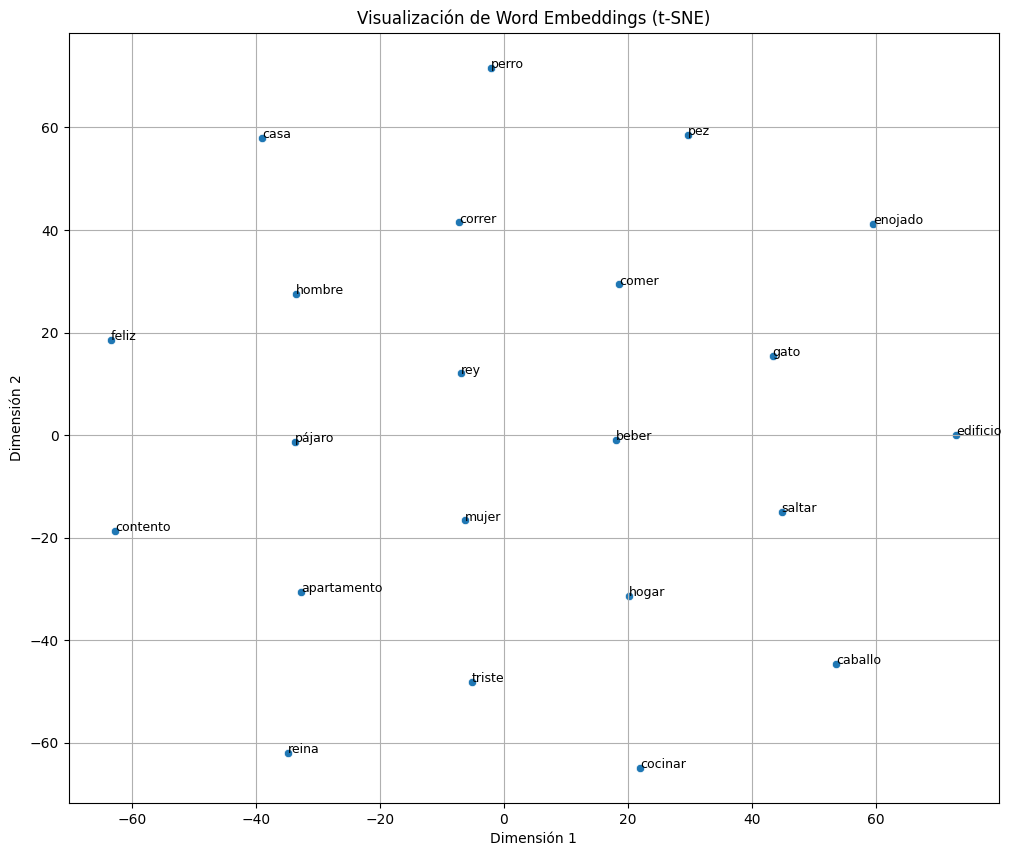

In [ ]:
# --- Visualización Opcional ---
if word_vectors:
    # Lista de palabras para visualizar (elegir grupos relacionados)
    palabras_a_visualizar = [
        'perro', 'gato', 'caballo', 'pez', 'pájaro', # Animales
        'casa', 'apartamento', 'hogar', 'edificio', # Hogar
        'comer', 'beber', 'cocinar', 'correr', 'saltar', # Verbos
        'feliz', 'contento', 'triste', 'enojado', # Emociones
        'rey', 'reina', 'hombre', 'mujer' # Relación clásica
    ]

    # Filtrar palabras que SÍ están en el vocabulario
    palabras_presentes = [p for p in palabras_a_visualizar if p in word_vectors]
    vectores_presentes = [word_vectors[p] for p in palabras_presentes]

    if len(vectores_presentes) > 1: # Necesitamos al menos 2 puntos para visualizar
        print(f"\nVisualizando {len(palabras_presentes)} palabras...")

        # Reducción de dimensionalidad con t-SNE (suele dar mejores clusters visuales)
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(palabras_presentes)-1)) # Perplexity debe ser menor que n_samples
        vectores_2d = tsne.fit_transform(np.array(vectores_presentes))

        # Crear el gráfico
        plt.figure(figsize=(12, 10))
        sns.scatterplot(x=vectores_2d[:, 0], y=vectores_2d[:, 1])

        # Añadir etiquetas a los puntos
        for i, palabra in enumerate(palabras_presentes):
            plt.annotate(palabra, (vectores_2d[i, 0], vectores_2d[i, 1]), fontsize=9)

        plt.title('Visualización de Word Embeddings (t-SNE)')
        plt.xlabel('Dimensión 1')
        plt.ylabel('Dimensión 2')
        plt.grid(True)
        plt.show()
    else:
        print("No hay suficientes palabras presentes en el vocabulario para visualizar.")

else:
    print("\nNo se pudieron cargar los vectores. Saltando la visualización.")

# 9. Micro-Laboratorio (Ejercicio Práctico)

**Consigna:** (Asumiendo que `word_vectors` se cargó correctamente)

1.  **Exploración de Similitud:**
    *   Elegir 5 palabras que les interesen (intenten variar: un lugar, una profesión, un concepto abstracto, una comida, un sentimiento).
    *   Para cada una, usar `word_vectors.most_similar()` para encontrar las 5 palabras más parecidas.
    *   Anotar los resultados. ¿Les parecen lógicos? ¿Hay alguna similitud sorprendente o extraña?

2.  **Prueba de Analogías:**
    *   Inventar y probar 3 analogías diferentes usando `word_vectors.most_similar(positive=[...], negative=[...])`.
    *   Ideas:
        *   `programador` es a `computadora` como `médico` es a `?`
        *   `Argentina` es a `peso` como `Japón` es a `?`
        *   `caminar` es a `pierna` como `hablar` es a `?`
    *   Verificar que todas las palabras de la analogía estén en el vocabulario antes de probarla.
    *   Anotar los resultados. ¿Funcionan las analogías como esperaban?

3.  **(Opcional) Medir Similitud:**
    *   Elegir 3 pares de palabras:
        *   Un par de sinónimos claros (ej: `estudiante`, `alumno`).
        *   Un par de antónimos (ej: `grande`, `pequeño`).
        *   Un par de palabras no relacionadas (ej: `nube`, `zapato`).
    *   Calcular `word_vectors.similarity()` para cada par.
    *   ¿Los valores de similitud reflejan la relación entre las palabras? (Esperamos alta para sinónimos, baja/media-baja para no relacionadas, y ¿qué pasa con antónimos?).

**¡Asegúrense de que las palabras que usan existan en `word_vectors`!**

# 10. Brainstorming: Sesgos en Embeddings

Hemos visto que los embeddings capturan relaciones del lenguaje tal como aparecen en los datos de entrenamiento (el corpus masivo).

**Pregunta clave:** Si esos datos contienen **sesgos sociales** (de género, raciales, de profesión, etc.), ¿qué creen que pasará con los embeddings?

*   ¿Se reflejarán esos sesgos en las relaciones entre vectores? (Pista: ¡Sí!)
    *   Ejemplo famoso: `doctor - hombre + mujer = ?` a veces da `enfermera` en modelos entrenados en textos antiguos o sesgados. `programador - hombre + mujer = ?` podía dar `ama de casa`.
*   ¿Qué implicancias tiene esto si usamos estos embeddings para tareas como selección de personal, análisis de opiniones, o generación de texto?
*   Si el corpus no representa bien la diversidad lingüística (dialectos, jergas, lenguaje inclusivo), ¿cómo afectará eso a los embeddings de esas palabras (si es que existen)?
*   **¿Cómo podemos entrenar word embeddings que sean más inclusivos y representativos?** ¿Es posible "limpiar" o "corregir" (debias) los embeddings pre-entrenados? ¿Es nuestra responsabilidad como desarrolladores ser conscientes de esto y mitigarlo?

**(Discusión en grupo)**

# GUÍA DE ESTUDIO - WORD EMBEDDINGS Y WORD2VEC

## Preguntas y Respuestas Clave

### **Revolución Conceptual**

**P: ¿Cuál es la diferencia fundamental entre BoW/TF-IDF y Word Embeddings?**  
R: BoW/TF-IDF crea vectores dispersos de alta dimensión (una por palabra del vocabulario). Word Embeddings crea vectores densos de baja dimensión (ej: 300) donde palabras similares están cerca geométricamente.

**P: ¿Qué significa que los embeddings capturen "semántica"?**  
R: Que palabras con significados similares tienen vectores similares. "auto" y "coche" estarán cerca en el espacio vectorial, no en dimensiones separadas.

**P: ¿Qué es la "álgebra de palabras" en embeddings?**  
R: La capacidad de hacer operaciones matemáticas que preservan relaciones semánticas: vector('rey') - vector('hombre') + vector('mujer') ≈ vector('reina').

### **Arquitecturas Word2Vec**

**P: ¿Cuál es la diferencia entre CBOW y Skip-gram?**  
R: CBOW predice palabra central dado contexto (rápido, bueno para palabras frecuentes). Skip-gram predice contexto dada palabra central (lento, mejor para palabras raras).

**P: ¿Qué es la "hipótesis distribucional"?**  
R: "Una palabra se conoce por las compañías que mantiene". Palabras que aparecen en contextos similares tienen significados similares.

### **Implementación Práctica**

**P: ¿Por qué usamos vectores pre-entrenados en lugar de entrenar desde cero?**  
R: Entrenar requiere corpus masivos (millones de palabras) y días de computación. Los modelos pre-entrenados ya capturan patrones del idioma.

**P: ¿Qué hace gensim.KeyedVectors?**  
R: Permite cargar y manipular vectores pre-entrenados sin necesidad de re-entrenar. Incluye funciones para similitud y analogías.

**P: ¿Cómo verificar si una palabra está en el vocabulario?**  
R: `palabra in word_vectors` antes de usar most_similar() o similarity() para evitar errores.

### **Análisis Semántico**

**P: ¿Qué indica un valor de similitud coseno alto entre dos palabras?**  
R: Que sus vectores apuntan en direcciones similares, sugiriendo relación semántica. Valores entre 0.3-0.7 son típicamente significativos.

**P: ¿Por qué algunas analogías funcionan mejor que otras?**  
R: Depende de qué tan consistentemente aparezcan esas relaciones en el corpus de entrenamiento. Relaciones muy frecuentes se capturan mejor.

### **Limitaciones Importantes**

**P: ¿Qué es el problema OOV (Out-of-Vocabulary)?**  
R: Palabras no vistas durante entrenamiento no tienen vector. Word2Vec clásico no puede manejar palabras nuevas, errores tipográficos, o neologismos.

**P: ¿Cómo reflejan sesgos los embeddings?**  
R: Si el corpus contiene sesgos sociales, los vectores los perpetúan. "doctor - hombre + mujer" podría dar "enfermera" en modelos sesgados.

## Puntos Clave para Recordar

1. **Word2Vec captura semántica** que BoW/TF-IDF ignora completamente
2. **Vectores densos de 300D > vectores dispersos de 50,000D**
3. **Similitud geométrica = similitud semántica**
4. **Analogías revelan estructura del lenguaje capturada**
5. **Siempre verificar vocabulario** antes de usar palabras
6. **Modelos pre-entrenados son la norma** para uso práctico

## Errores Comunes a Evitar

- Intentar usar palabras no presentes en vocabulario sin verificar
- Esperar que analogías muy específicas siempre funcionen
- Ignorar sesgos inherentes en modelos pre-entrenados
- Comparar palabras muy diferentes y esperar similitud alta
- No considerar que el modelo refleja el corpus de entrenamiento

## Conexión con Próxima Clase

Word2Vec tiene limitaciones: problema OOV y vocabulario fijo. La próxima clase explorará **FastText** y **GloVe**: arquitecturas que resuelven estos problemas y manejan palabras desconocidas.

---
*Consejo: Experimenta con analogías culturales argentinas: "Messi - fútbol + música = ?". ¿El modelo captura relaciones culturales locales?*